<div class="alert alert-block alert-info">
<b>Deadline:</b> March 9, 2022 (Wednesday) 23:00
</div>

# Exercise 1. Train a multilayer perceptron (MLP) network in numpy.

In this exercise, we implement training of a multilayer perceptron network using the `numpy` library.
* We implement forward and backward computations required for computing the gradients with backpropagation.
* We train an MLP on a toy data set.

We will implement an MLP with two hidden layers like shown in this figure:

<img src="mlp.png" width=300 style="float: top;">

We will build the following computational graph:

<img src="mlp_compgraph.png" width=600 style="float: top;">

Note that the computational graph contains a mean-squared error (MSE) loss because we solve a regression problem.

Recall what we discussed in the lecture:

<img src="backprop_software.png" width=800 style="float: top;">

In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
skip_training = True  # Set this flag to True before validation and submission

In [3]:
# During grading, this cell sets skip_training to True
# skip_training = True

## 1. Gradient of the loss

We start by implementing the last block of the computational graph which is the mean-squared error loss:
$$
c = \frac{1}{N} \sum_{i=1}^N (y_i - t_i)^2
$$
where $y_i$ are the elements of an input vector $\mathbf{y}$ and $t_i$ are the elements of the target vector $\mathbf{t}$.

In the code below, we define a class that performs forward and backward computations of this loss function. Your task is to implement the `backward` function which should compute the gradient $\frac{\partial c}{\partial \mathbf{y}}$.

Note that we process all $N$ training examples at the same time. Therefore, our implementation operates with two-dimensional arrays of shape `(n_samples, some_size)` where `n_samples` is the number $N$ of training samples and `some_size` is the size of an intermediate vector produced inside the MLP (e.g., the number of neurons in a hidden layer).

In [4]:
class MSELoss:
    def forward(self, y, target):
        """ 
        Args:
          y of shape (n_samples, ysize): Inputs of the loss function (can be, e.g., an output of a neural network).
          target of shape (n_samples, ysize): Targets.
        
        Returns:
          loss (float): The loss value.
        """
        self.diff = diff = y - target  # Keep this for backward computations
        c = np.sum(np.square(diff)) / diff.size
        return c

    def backward(self):
        """
        Returns:
          dy of shape (n_samples, ysize): Gradient of the MSE loss wrt the inputs.
        """
        assert hasattr(self, 'diff'), "Need to call forward() first"
        # YOUR CODE HERE
        dy=2*self.diff/self.diff.size
        
        return dy
        raise NotImplementedError()

In [5]:
def test_MSELoss_shapes():
    y = np.random.randn(3)
    target = np.zeros(3)  # Dummy target
    loss = MSELoss()  # Create the loss
    loss_value = loss.forward(y, target)  # Do forward computations
    dy = loss.backward()  # Do backward computations
    assert dy.shape == y.shape, f"Bad dy.shape: {dy.shape}"
    print('Success')

test_MSELoss_shapes()

Success


We can test our implementation by comparing the results of our backward computations with a [numerical estimate](https://en.wikipedia.org/wiki/Numerical_differentiation) of the gradient: Suppose we have function 
$f(\mathbf{x})$ of a vector input $\mathbf{x}$, then the gradient can be estimated numerically at a (randomly chosen) input $\mathbf{x}$ by
$$ \nabla f(\mathbf{x}) \approx \frac{f(\mathbf{x} + \epsilon) - f(\mathbf{x} - \epsilon)}{2\epsilon}$$
using small $\epsilon$. Note that the numerical gradient is an approximation of the analytical one and therefore there will be a small numerical difference between them.

The function that we import in the cell below implements numerical computations of the gradient of a given function.

In [6]:
from tests import numerical_gradient

In [7]:
# We now compare our analytical computations of the gradient with its numerical estimate
def test_MSELoss_backward():
    y = np.random.randn(3)
    target = np.zeros(3)  # Dummy target
    loss = MSELoss()  # Create the loss
    loss_value = loss.forward(y, target)  # Do forward computations

    dy = loss.backward()
    print('Analytical gradient:\n', dy)
    dy_num = numerical_gradient(lambda y: loss.forward(y, target), y)
    print('Numerical gradient:\n', dy_num[0])
    assert np.allclose(dy, dy_num), 'Analytical and numerical results differ'
    print('Success')

test_MSELoss_backward()

Analytical gradient:
 [-0.21038304 -0.66939583 -0.14608303]
Numerical gradient:
 [-0.21038304 -0.66939583 -0.14608303]
Success


In [8]:
# This cell tests MSELoss

## 2. Linear layer

Next we implement a linear layer.

The forward computations of the linear layer are
$$
\mathbf{y} = \mathbf{W} \mathbf{x} + \mathbf{b}.
$$

In the backward pass, the linear layer receives the gradients wrt to the outputs $\frac{\partial c}{\partial \mathbf{y}}$ and it needs to compute:
* the gradients wrt the layer parameters $\mathbf{W}$ and $\mathbf{b}$
* the gradient $\frac{\partial c}{\partial \mathbf{x}}$ wrt the inputs.

In the cell below, we define a class that resembles class [`nn.Linear`](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html?highlight=nn%20linear#torch.nn.Linear) of pytorch. It calls functions `linear_forward` and `linear_backward` that implement the forward and backward computations. We implmented it this way because it makes it easier to test `linear_forward` and `linear_backward`.

In [9]:
class Linear:
    def __init__(self, in_features, out_features):
        """
        Args:
          in_features (int): Number of input features which should be equal to xsize.
          out_features (out): Number of output features which should be equal to ysize.
        """
        self.in_features = in_features
        self.out_features = out_features
        
        # Initialize the weights
        bound = 3 / np.sqrt(in_features)
        self.W = np.random.uniform(-bound, bound, (out_features, in_features))
        bound = 1 / np.sqrt(in_features)
        self.b = np.random.uniform(-bound, bound, out_features)

        self.grad_W = None  # Attribute to store the gradients wrt W
        self.grad_b = None  # Attribute to store the gradients wrt b

    def forward(self, x):
        """
        Args:
          x of shape (n_samples, xsize): Inputs.
        
        Returns:
          y of shape (n_samples, ysize): Outputs.
        """
        self.x = x  # Keep this for backward computations
        return linear_forward(x, self.W, self.b)

    def backward(self, dy):
        """
        Args:
          dy of shape (n_samples, ysize): Gradient of a loss wrt outputs.
        
        Returns:
          dx of shape (n_samples, xsize): Gradient of a loss wrt inputs.
        """
        assert hasattr(self, 'x'), "Need to call forward() first"
        assert dy.ndim == 2 and dy.shape[1] == self.W.shape[0]
        dx, self.grad_W, self.grad_b = linear_backward(dy, self.x, self.W, self.b)
        return dx

Your task is to implement `linear_forward` and `linear_backward`.

In [10]:
def linear_forward(x, W, b):
    """Forward computations in the linear layer:
        y = W x + b

    Args:
      x of shape (n_samples, xsize): Inputs.
      W of shape (ysize, xsize): Weight matrix.
      b of shape (ysize,): Bias term.

    Returns:
      y of shape (n_samples, ysize): Outputs.
    """
    # YOUR CODE HERE 
    #import pdb; pdb.set_trace()
    y=np.dot(x,W.T)+b
    
    return y

    raise NotImplementedError()

    
def linear_backward(dy, x, W, b):
    """Backward computations in the linear layer.

    Args:
      dy of shape (n_samples, ysize): Gradient of a loss wrt outputs.
      x of shape (n_samples, xsize): Inputs.
      W of shape (ysize, xsize): Weight matrix.
      b of shape (ysize,): Bias term.

    Returns:
      dx of shape (n_samples, xsize): Gradient of a loss wrt inputs.
      dW of shape (ysize, xsize): Gradient wrt weight matrix W.
      db of shape (ysize,): Gradient wrt bias term b.
    """
    assert dy.ndim == 2 and dy.shape[1] == W.shape[0]
    # YOUR CODE HERE
    
    m=dy.shape[1]
    dx=np.dot(dy,W)
    
    dW=np.dot(dy.T,x)
    #(1./m)*
    db= np.sum(dy,axis = 0)
    #import pdb; pdb.set_trace()
    
    return dx,dW,db
    raise NotImplementedError()

In [11]:
# We test the shapes of the outputs
def test_linear_shapes():
    n_samples = 4
    x = np.random.randn(n_samples, 2)
    W = np.random.randn(3, 2)
    b = np.random.randn(3)

    # Test shapes
    y = linear_forward(x, W, b)
    dy = np.arange(n_samples * 3).reshape((n_samples, 3))
    dx, dW, db = linear_backward(dy, x, W, b)
    assert dx.shape == x.shape, f"Bad dx.shape={dx.shape}, x.shape={x.shape}"
    assert dW.shape == W.shape, f"Bad dW.shape={dW.shape}, W.shape={W.shape}"
    assert db.shape == b.shape, f"Bad db.shape={db.shape}, b.shape={b.shape}"

    print('Success')

test_linear_shapes()

Success


We can again test the backward computations by numerical differentiation.

Note that function `numerical_gradient` imported above accepts functions `fun` that works only with *one-dimensional arrays* as inputs and outputs.

Suppose we have function `fun(X)` which accepts a two-dimensional array `X` of shape `(n1, n2)` as input and produces a one-dimensional array `y` of shape `(ny,)` as output. We want to compute partial derivatives
`d y[i] / d X[k,l]` for each output element `y[i]` and each element `X[k,l]` of the input matrix. We can to it in the following way.

First, we define a function with one-dimensional inputs such that it can be passed to our `numerical_gradient`
function. Function `fun2` reshapes a one-dimensional array passed to it and calls function `fun`:
```
fun2 = lambda A: fun(A.reshape(n1, n2))
```

Then we can call the `numerical_gradient` function:
```
A = np.random.randn(n1, n2)
dA = numerical_gradient(fun2, A.flatten())
```
which will produce a two dimensional array of shape `(ny, n1*n2)` that will contain the required partial
derivatives.


In [12]:
# We test the backward computations of d/dW by numerical differentiation
def test_linear_numerically():
    n_samples = 4
    x = np.random.randn(n_samples, 2)
    W = np.random.randn(3, 2)
    b = np.random.randn(3)

    y = linear_forward(x, W, b)
    dy = np.arange(n_samples * 3).reshape((n_samples, 3))
    dx, dW, db = linear_backward(dy, x, W, b)

    print('Analytical gradient:\n', dW)
    dW_num = numerical_gradient(lambda W: linear_forward(x, W.reshape(3, 2), b).flatten(), W.flatten())
    dW_num = dW_num.reshape(y.shape + W.shape)
    expected = (dy[:, :, None, None] * dW_num).sum(axis=(0,1))
    print('Numerical gradient:\n', expected)
    assert np.allclose(dW, expected), 'Analytical and numerical results differ'
    print('Success')

test_linear_numerically()

Analytical gradient:
 [[3.89361943 1.02744478]
 [3.26700952 1.62131336]
 [2.64039961 2.21518194]]
Numerical gradient:
 [[3.89361943 1.02744478]
 [3.26700952 1.62131336]
 [2.64039961 2.21518194]]
Success


We recommend you to compare analytical and numerical computations of the gradients also wrt input `x` and bias term `b`.

In [13]:
# This cell tests linear_forward and linear_backward

In [14]:
# This cell tests linear_forward and linear_backward

In [15]:
# This cell tests linear_forward and linear_backward

## 3. The Tanh activation function

Next we implement the Tanh activation function. The activation function is applied *element-wise* to input vector $\mathbf{x}$ to produce outputs $\mathbf{y}$:
$$
\mathbf{y} = \text{tanh}(\mathbf{x}) \quad \text{such that} \quad y_i = \text{tanh}(x_i).
$$

When we backpropagate through that block, we need to transform the gradients $\frac{\partial c}{\partial \mathbf{y}}$ wrt to the outputs into the gradients wrt the inputs $\frac{\partial c}{\partial \mathbf{x}}$. Your task is to implement the forward and backward computations.

Notes:
* We recommend you to compare analytical and numerical computations of the gradient.
* If you use function `numerical_gradient` to differentiate numerically `Tanh.forward()` using a one-dimensional array `x` as input, the output of `numerical_gradient` is a two-dimensional array (Jacobian matrix). We are interested only in the diagonal elements of that array because the nonlinearity is applied *element-wise*.

In [16]:
class Tanh:
    def forward(self, x):
        """
        Args:
          x of shape (n_features,): Inputs.
        
        Returns:
          y of shape (n_features,): Outputs.
        """
        # YOUR CODE HERE
        self.x=x
        
        y=np.tanh(x)
        #import pdb; pdb.set_trace()
        return y
        raise NotImplementedError()

    def backward(self, dy):
        """
        Args:
          dy of shape (n_features,): Gradient of a loss wrt outputs.
        
        Returns:
          dx of shape (n_features,): Gradient of a loss wrt inputs.
        """
        assert hasattr(self, 'x'), "Need to call forward() first."
        # YOUR CODE HERE
        
        dx=dy*(1-np.square(np.tanh(self.x)))
        return dx
        raise NotImplementedError()

In [17]:
def test_Tanh_shapes():
    x = np.random.randn(3)
    act_fn = Tanh()
    y = act_fn.forward(x)
    dy = np.arange(1, 4)
    dx = act_fn.backward(dy)
    assert dx.shape == x.shape, f"Bad dx.shape: {dx.shape}"
    print('Success')

test_Tanh_shapes()

Success


## 4. Multilayer Perceptron (MLP)

In the cell below, you need to implement an MLP with two hidden layers and `Tanh` nonlinearity. Use instances of classes `Linear` and `Tanh` in your implementation.

Note:
* For testing purposes, the instances of `Linear` and `Tanh` classes should be attributes of class `MLP` such as attribute `fc1` in the example below:
```
    def __init__(self, in_features, hidden_size1, hidden_size2, out_features):
        self.fc1 = Linear(...)
```

In [18]:
class MLP:
    def __init__(self, in_features, hidden_size1, hidden_size2, out_features):
        """
        Args:
          in_features (int): Number of inputs which should be equal to xsize.
          hidden_size1 (int): Number of units in the first hidden layer.
          hidden_size2 (int): Number of units in the second hidden layer.
          out_features (int): Number of outputs which should be equal to ysize.
        """
        # YOUR CODE HERE
        #import pdb; pdb.set_trace()
        
        self.L1=Linear(in_features,hidden_size1)
        self.A1=Tanh()
        self.L2=Linear(hidden_size1,hidden_size2)
        self.A2=Tanh()
        self.L3=Linear(hidden_size2,out_features)
        
        #raise NotImplementedError()

    def forward(self, x):
        """
        Args:
          x of shape (n_samples, xsize): Inputs.
        
        Returns:
          y of shape (n_samples, ysize): Outputs.
        """
        # YOUR CODE HERE
        h1=self.L1.forward(x)
        h2=self.A1.forward(h1)
        h3=self.L2.forward(h2)
        h4=self.A2.forward(h3)
        h5=self.L3.forward(h4)
        y=h5
    
        return y
        raise NotImplementedError()

    def backward(self, dy):
        """
        Args:
          dy of shape (n_samples, ysize): Gradient of a loss wrt outputs.
        
        Returns:
          dx of shape (n_samples, xsize): Gradient of a loss wrt inputs.
        """
        # YOUR CODE HERE
        h4=self.L3.backward(dy)
        h3=self.A2.backward(h4)
        h2=self.L2.backward(h3)
        h1=self.A1.backward(h2)
        dx=self.L1.backward(h1)
        
        return dx
        raise NotImplementedError()

In [19]:
def test_MLP_shapes():
    n_samples = 10
    x = np.random.randn(n_samples, 1)
    mlp_batch = MLP(1, 10, 20, 1)
    y = mlp_batch.forward(x)

    dy = np.arange(n_samples).reshape((n_samples, 1))   # Dummy gradient of a loss function wrt MLP's outputs.
    dx = mlp_batch.backward(dy)
    assert dx.shape == x.shape, f"Bad dx.shape={dx.shape}, x.shape={x.shape}"
    print('Success')

test_MLP_shapes()

Success


In [20]:
# This cell tests MLP

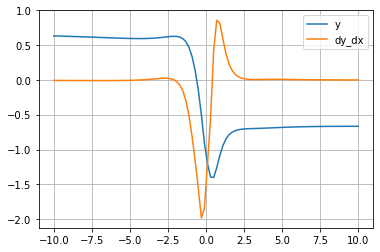

In [21]:
# Let's create an MLP with random weights and compute the derivative wrt the one-dimensional input
def test_MLP_derivative():
    n_samples = 100
    x = np.linspace(-10, 10, n_samples)
    mlp_batch = MLP(1, 10, 20, 1)
    y = mlp_batch.forward(x.reshape((n_samples, 1))).flatten()

    dy_dx = mlp_batch.backward(np.ones((n_samples, 1))).flatten()

    fig, ax = plt.subplots()
    ax.plot(x, y)
    ax.plot(x, dy_dx)
    ax.grid(True)
    ax.legend(['y', 'dy_dx'])

test_MLP_derivative()

You can visually inspect whether the computations of the derivative seem correct.

More importantly, we can compute the gradient of a loss wrt the parameters of the MLP. The gradients can be used to update the parameters using gradient descent.

## 5. Training MLP network with backpropagation

Now let us use our code to train an MLP network.

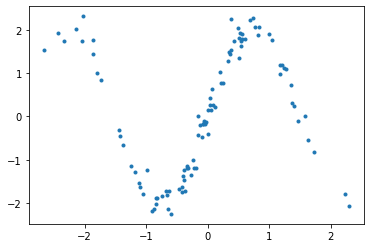

In [22]:
# Generate toy data
def get_data():
    np.random.seed(2)
    x = np.random.randn(100, 1)
    x = np.sort(x, axis=0)

    targets = 2 * np.sin(x * 2 * np.pi / 3)
    targets = targets + 0.2 * np.random.randn(*targets.shape)

    return x, targets

x, targets = get_data()
# Plot the data
fig, ax = plt.subplots(1)
ax.plot(x, targets, '.')

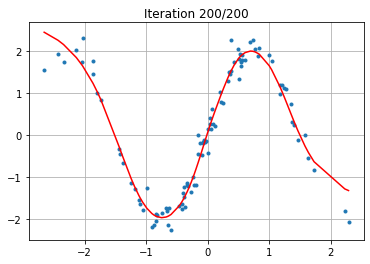

In [23]:
# And train an MLP network using gradient descent
from IPython import display

mlp = MLP(1, 10, 11, 1)  # Create MLP network
loss = MSELoss()  # Create loss
if not skip_training:  # The trained MLP is not tested
    fig, ax = plt.subplots(1)
    ax.plot(x, targets, '.')
    learning_rate = 0.05
    n_epochs = 1 if skip_training else 200
    for i in range(n_epochs):
        # Forward computations
        y = mlp.forward(x)
        c = loss.forward(y, targets)

        # Backward computations
        dy = loss.backward()
        dx = mlp.backward(dy)

        # Gradient descent update
        #learning_rate *= 0.99  # Learning rate annealing
        for module in mlp.__dict__.values():
            if hasattr(module, 'W'):
                module.W = module.W - module.grad_W * learning_rate
                module.b = module.b - module.grad_b * learning_rate

        ax.clear()
        ax.plot(x, targets, '.')
        ax.plot(x, y, 'r-')
        ax.grid(True)
        ax.set_title('Iteration %d/%d' % (i+1, n_epochs))
        display.clear_output(wait=True)
        display.display(fig)
        plt.pause(0.005)
    display.clear_output(wait=True)

If you implement the MLP correctly, you will see that the learned function fits the training data.

In [24]:
# Save the model to disk (the pth-files will be submitted automatically together with your notebook)
# Set confirm=False if you do not want to be asked for confirmation before saving.
if not skip_training:
    try:
        save = input('Do you want to save the model (type yes to confirm)? ').lower()
        if save != 'yes':
            print('Model not saved.')
        else:
            with open('1_mlp_numpy.pkl', 'wb') as file:
                pickle.dump(mlp, file)
            print('Model saved to 1_mlp_numpy.pkl.')
    except:
        raise Exception('The notebook should be run or validated with skip_training=True.')

Do you want to save the model (type yes to confirm)? yes
Model saved to 1_mlp_numpy.pkl.


In [25]:
if skip_training:
    with open('1_mlp_numpy.pkl', 'rb') as file:
        mlp = pickle.load(file)
        print('File loaded.')

In [26]:
y = mlp.forward(x)
c = loss.forward(y, targets)
print(f'MSE loss: {c}')
assert c < 0.1, 'Poorly trained MLP'

MSE loss: 0.07085682086585905


In [27]:
# This cell is used for grading

<div class="alert alert-block alert-info">
<b>Conclusions</b>
</div>

Now you have implemented backpropagation and trained an MLP network using gradient descent.

PyTorch makes it easier to create neural networks with different architectures and optimize its parameters using (variants of) gradient descent:
* It contains multiple building blocks with forward and backward computations implemented.
* It implements optimization methods that work well for neural networks.
* Computations can be performed either on GPU or CPU using the same code.